# Notebook 1: Data, shape components, and iterative window search

---

<font size="3"> This notebook is the first of three methods notebooks associated with the pub "*Comparative analyses reveal substantial movement variation among amoeboid cells*". Here, shape components will be calculated (via PCA) from cell images and a search to determine the optimal window size to use for creating a crawling behavior space will be run. Cell images are expected to be segmented, centered, and scaled/normalized so that each cell posseses a similar area and overall orientation.  

<font size="3"> To get going, you will need to download the source data and supporting functions from github (available at https://github.com/ryanayork/comparative_amoeboid_crawling) and point R toward the corresponding directory (here named 'comparative_amoeboid_crawling'). 

<font size="3"> **Note:** this notebook contains lines to optionally save out intermediate files. For the sake of reproducing the published figures exactly, pre-computed versions of these files have also been made available via github.

---

## Initiating workspace and loading data

<font size="3"> Set working directory

In [1]:
setwd('~/Desktop/comparative_amoeboid_crawling/')

<font size="3"> Source functions

In [2]:
suppressPackageStartupMessages(source('01_functions/crawling_functions.R'))

<font size="3"> Load and process image data (if desired)

In [3]:
#Set working directory
#setwd('00_data/cell_images/')

#List directories
#dirs = list.files()

#Loop through and load each cell type
#dat = list()
#for(i in 1:length(dirs)){
  
  #Load images
  #tmp = load_images(dirs[i])
  
  #Combine
  #x = do.call(rbind, lapply(tmp$images, function(x) do.call(rbind, x)))
  
  #Add rownames
  #rownames(x) = paste(rep(dirs[i], nrow(x)), tmp$names, 1:nrow(x), sep = '_')
  
  #Add to list
  #dat[[dirs[i]]] = x
  
  #Return to higher directory
  #setwd('../')
#}

<font size="3"> Save

In [4]:
#saveRDS(dat, '~/Desktop/comparative_amoeboid_crawling/00_data/imoto_et_al_features_all_cells_051822.RDS')

## Calculating shape components via PCA

<font size="3"> In this chunk we will use principal component analysis (PCA) to identify consistent 'shape components' from the processed cell images.  </font>

---

<font size="3"> Load data

In [5]:
dat = readRDS('00_data/imoto_et_al_features_all_cells_051822.RDS')

<font size="3"> Run principal components analysis

In [6]:
pca = prcomp(dat)

<font size="3"> Plot variance explained

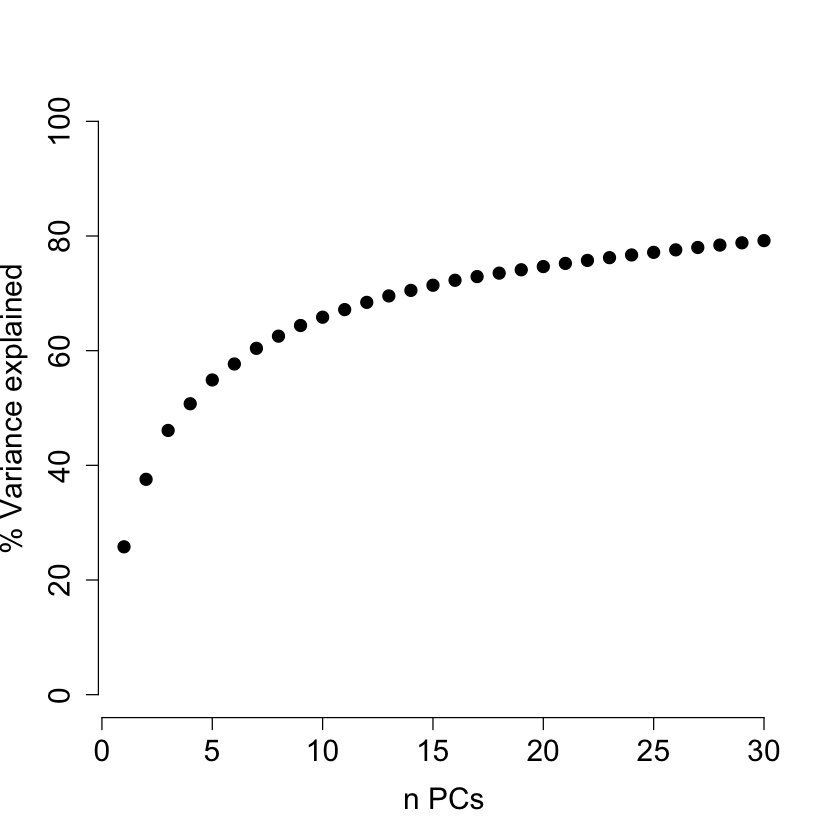

In [7]:
plot(cumsum((pca$sdev)^2/sum(((pca$sdev)^2)))[1:30]*100,
     ylab = '% Variance explained',
     xlab = 'n PCs', 
     pch = 20, 
     cex = 2,
     cex.axis = 1.5, 
     cex.lab = 1.5, 
     bty = 'n', 
     ylim = c(0,100))

---

<font size="3"> Judging from the above plot, it looks like the majority of variance is explained by the first ~5PCs and the overall distribution levels off at ~15PCs. 
   
<font size="3">Let's take a look at the eigenvectors to see which aspects of cell shape are described by each PC. 

---

<font size="3"> Plot eigenvectors (for first n components)

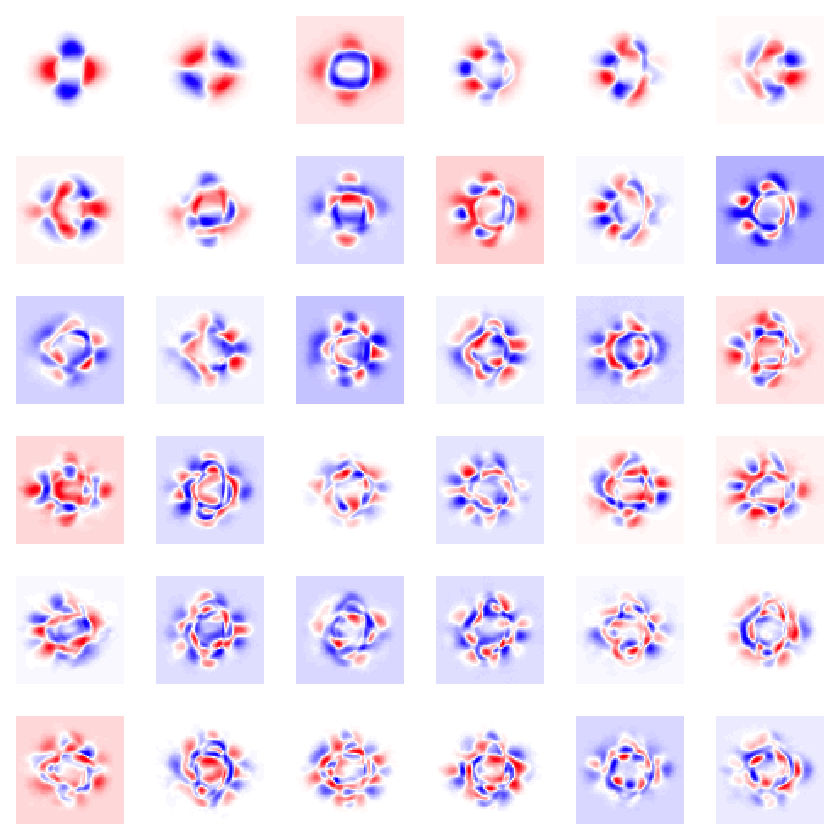

In [8]:
par(mfrow = c(6,6), mar = c(1,1,1,1))
invisible(apply(pca$rotation[,1:36], 2, function(x) image(matrix(x, nrow = 64),
                                                          col = gplots::bluered(100),
                                                          bty = 'n', 
                                                          xaxt = 'n', 
                                                          yaxt = 'n')))

<font size="3"> Extract informative PCs (for n components; here the first 15 PCs)

In [9]:
s = pca$x[,1:15]

<font size="3"> Calculate the autocorrelation of these PCs (useful for getting an initial sense of their temporal structure)

In [10]:
res = apply(s, 2, function(x) acf(x, lag = 50, plot = FALSE)$acf[,,1])

<font size="3"> Plot the autocorrelation distributions

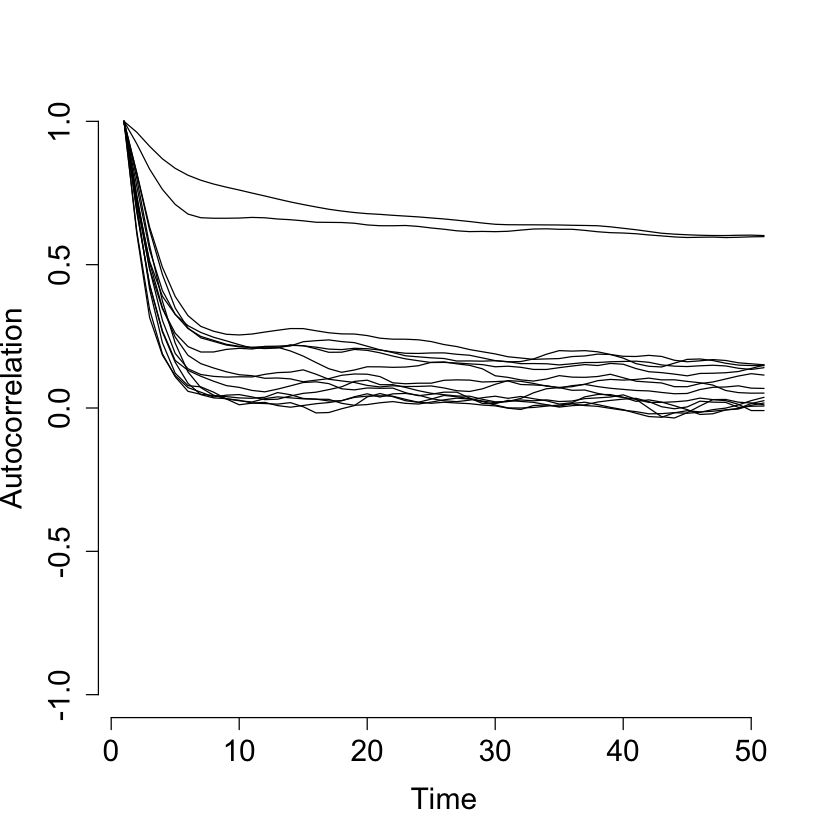

In [11]:
plot(res[,1], 
     type = 'l', 
     ylim = c(-1,1), 
     ylab = 'Autocorrelation', 
     bty = 'n',
     cex.axis = 1.5,
     cex.lab = 1.5,
     xlab = 'Time')
for(i in 2:ncol(res)){
  lines(res[,i])
}

<font size="3"> Save

In [12]:
#saveRDS(pca, '02_analysis_files/shape_pca_full.RDS')
#saveRDS(s, '02_analysis_files/shape_pca_15_pcs.RDS')

## Running the iterative window search

<font size="3"> Now that we have identified a reduced representation of the raw data (in the form of 15 shape components), we can begin to think making sense of how these features very over time and relate to movement. 
  
<font size="3"> A powerful way of representing the changing features over time is to embed them in a low-dimensional, continuous **'movement space'**. One can think of spaces like this as interpretable maps of what movements the different cells can do. Movements of individual cells over time can then be mapped in the space, producing unique **'trajectories'** between different movements.
  
<font size="3"> A key decision when producing one of these maps is to decide how to bin the features into windows. Using windows is important here since movements don't happen instantaneously; factors such as intertia make it so that movements occur over a variety of timescales, the length of which determine the overall structure of movement over time.
  
<font size="3"> In this chunk we will explore how using different window sizes effects the structure of the downstream **movement spaces**. 

<font size="3">This will be done by testing a range of window sizes (here, ranging in size from 1 frame to 50 frames) using an **'iterative window search'** procedure.  </font>

---

<font size="3"> Load PCs

In [13]:
setwd('~/Desktop/comparative_amoeboid_crawling/')
s = readRDS('02_analysis_files/shape_pca_15_pcs.RDS')

<font size="3"> Split data into n chunks (to allow for comparison across replicates during iterative window search)

In [14]:
s = list(s[1:500,], s[501:1000,], s[1001:1500,], s[1501:2000,], s[2001:2500,], s[2501:3000,],
         s[3001:3500,], s[3501:4000,], s[4001:4500,], s[4501:5000,], s[5001:5500,], s[5501:6000,],
         s[6001:6500,], s[6501:7000,], s[7001:7500,])

<font size="3"> Set up a range of window sizes to test (here 1 to 50 frames)

In [15]:
toSweep = 1:50

<font size="3"> Initialize an empty list to save results in

In [16]:
iterative_windows = list()

<font size="3"> Run the iterative window search and save results

In [17]:
#Progress bar
pb <- txtProgressBar(min = 0,      
                     max = length(toSweep), 
                     style = 3,    
                     width = 50,
                     char = ".")

for(i in 1:length(toSweep)){
    
  #Update progress bar
  setTxtProgressBar(pb, i)

  #Function
  iterative_windows[[as.character(toSweep[i])]] = invisible(iterative_umap(s,
                                                            plot = FALSE,
                                                            window_size = toSweep[i]))}

  |..................................................| 100%

<font size="3"> Save

In [18]:
saveRDS(iterative_windows, '02_analysis_files/iterative_windows.RDS')

## Analyzing iterative windows

<font size="3"> In the above chunk we generated a bunch of sample movement spaces using a range of window sizes (1 frame to 50 frames). Now, how to compare the results and determine the actual window size we want to use?

<font size="3"> To do this, we will empirically compare the movement spaces generated by the different window sizes. Specifically, we will analyze aspects of their structural and temporal properties using a variety of measures. 

<font size="3"> We will use **Procrustes distance** and **Euclidean distance** to assess variation in the global (**Procrustes**) and local (**Euclidean**) structure of the movement spaces. 
 
<font size="3"> We will then measure the **Recurrence** of each movement space to assess their temporal properties. Here, we define recurrence as the distribution of times it takes to return to specific regions of movement space. This is a useful measure of how stereotyped trajectories through movement space are, allowing us to infer which spaces seem to be capturing repepitive movement patterns.

<font size="3"> Finally, we will use some measures from Fractal geometry - the **Fractal dimension** and **Hurst exponent** - to infer local (**Fractal dimension**) and longer-term (**Hurst exponent**) structure in the trajectories through movement space. We are often looking for spaces with less long-term memory and more switching between states (i.e. **Hurst exponents** closer to 0.5 and lower values for the **Fractal dimension**)

---

<font size="3"> Load iterative windows results

In [19]:
iterative_windows = readRDS('02_analysis_files/iterative_windows.RDS')

<font size="3"> Select just UMAPs

In [20]:
iterative_windows = lapply(iterative_windows, function(x) x$umaps)

<font size="3"> Calculate Procrustes and Euclidean distance for all iterative window sizes

In [21]:
iterative_windows_pr = lapply(iterative_windows, function(y) run_procrustes(y)$procrustes)
iterative_windows_dist = lapply(iterative_windows, function(y) run_procrustes(y)$euclidean_distances)

<font size="3"> Plot results

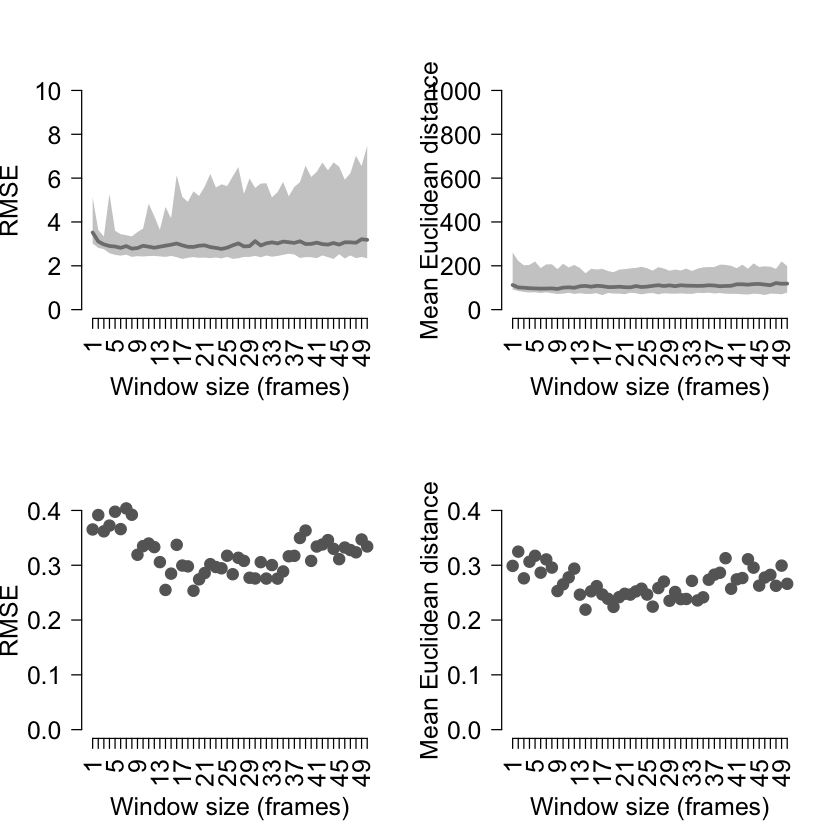

In [22]:
par(mfrow = c(2,2))
#Full distributions
#Procrustes
invisible(plot_results(iterative_windows_pr,
             ylim = c(0, 10),
             ylab = "RMSE",
             xlab = "Window size (frames)",
             plot_as_lines = TRUE))

#Euclidean
invisible(plot_results(iterative_windows_dist,
             ylim = c(0, 1000),
             ylab = "Mean Euclidean distance",
             xlab = "Window size (frames)",
             plot_as_lines = TRUE))

#As variance
#Procrustes
invisible(plot_variance(iterative_windows_pr,
                       ylim = c(0, 0.4),
                       ylab = "RMSE",
                       xlab = "Window size (frames)",
                       return = TRUE))

#Euclidean
invisible(plot_variance(iterative_windows_dist,
                        ylim = c(0, 0.4),
                        ylab = "Mean Euclidean distance",
                        xlab = "Window size (frames)"))

<font size="3"> Calculate recurrence

In [23]:
#Initiate empty list to save results
recurrence = list()

#Calculate recurrence for each window size
for(i in 1:length(iterative_windows)){
  recurrence[[as.character(names(iterative_windows)[i])]] = calculate_recurrence(iterative_windows[[i]],
                                                                                 n_bins = 16)}

<font size="3"> Plot the distribution of recurrence times across replicates

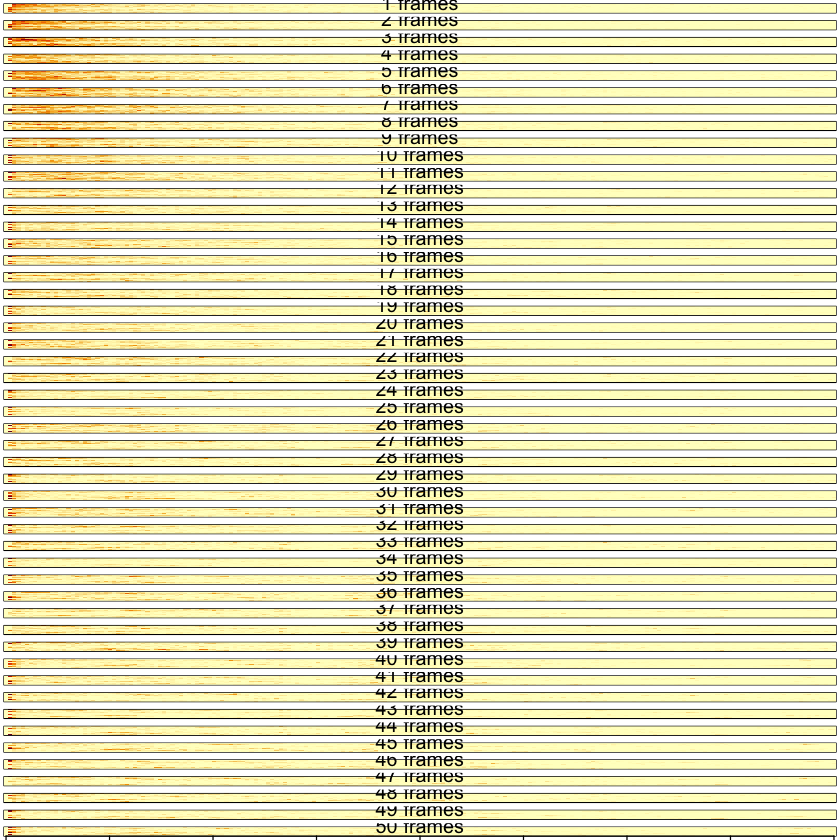

In [24]:
plot_recurrence(recurrence,
                mar = c(0.25,0.25,0.25,0.25))

<font size="3"> Plot diagnostics of the recurrence time distributions

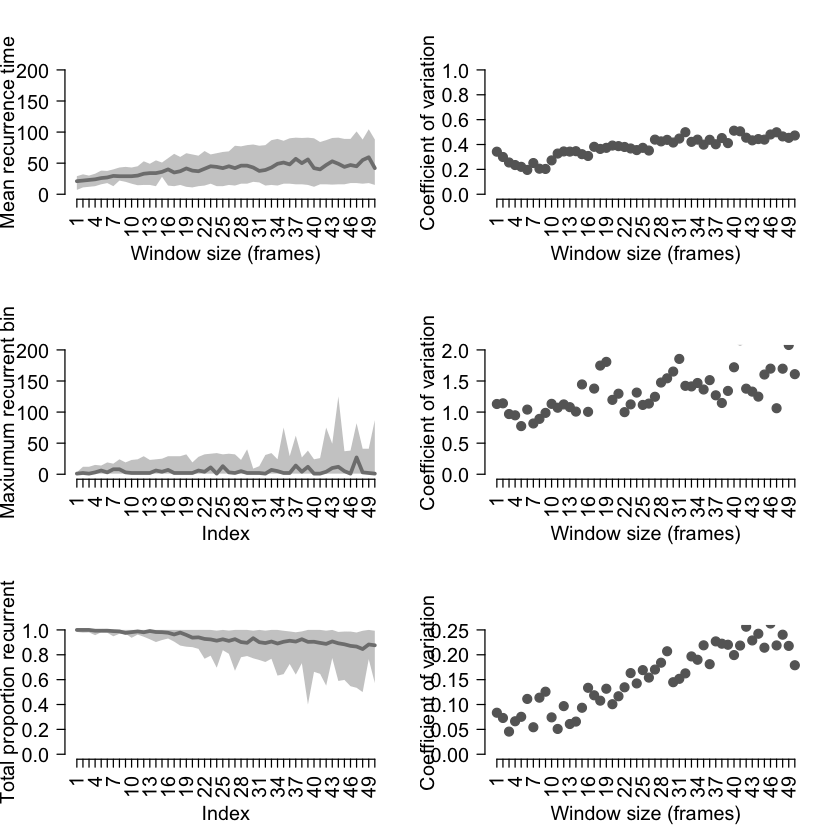

In [25]:
par(mfrow = c(3,2))

#Mean recurrence time per bin
means = lapply(recurrence, function(x) unlist(lapply(x, function(y) (median(y$recurrences)))))
invisible(plot_results(means,
             xlab = "Window size (frames)",
             ylab = "Mean recurrence time",
             ylim = c(0,200),
             plot_as_lines = TRUE))

invisible(plot_variance(means,
              xlab = "Window size (frames)",
              ylab = "Coefficient of variation",
              ylim = c(0,1)))
                                                     
#Distribution of window sizes with the maximum # of recurrent bins in behavior space
max_bin = lapply(recurrence, function(x) unlist(lapply(x, function(y) (which.max(y$histogram$counts)))))
invisible(plot_results(max_bin,
             ylim = c(0,200),
             plot_as_lines = TRUE,
             ylab = "Maxiumum recurrent bin"))
                                                       
invisible(plot_variance(max_bin,
              xlab = "Window size (frames)",
              ylab = "Coefficient of variation",
              ylim = c(0,2)))
                                                       
#Total percent of behavior space bins that are recurrent
percent_recurrent = lapply(recurrence, function(x) unlist(lapply(x, function(y) y$total_proportion_recurrent)))
invisible(plot_results(percent_recurrent,
             ylim = c(0,1),
             plot_as_lines = TRUE,
             ylab = "Total proportion recurrent"))

invisible(plot_variance(percent_recurrent,
              xlab = "Window size (frames)",
              ylab = "Coefficient of variation",
              ylim = c(0,0.25)))

<font size="3"> Calculate Hurst exponent of each behavior space as a function of window size

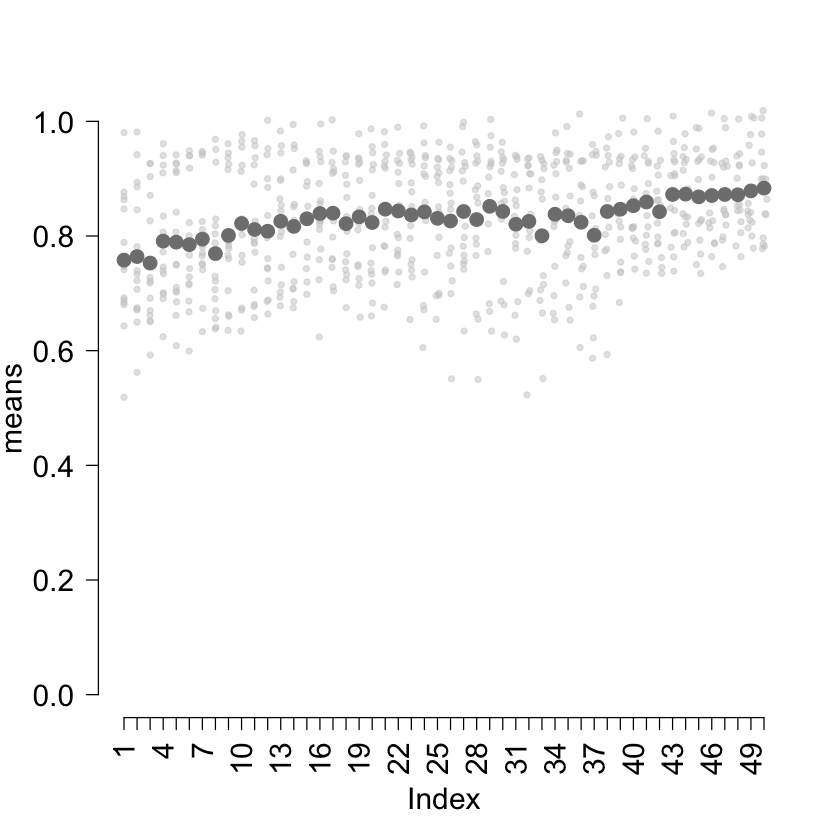

In [26]:
hurst = list()
for(i in 1:length(iterative_windows)){
  x = c()
  for(j in 1:length(iterative_windows[[i]])){
    x = c(x, invisible(pracma::hurstexp(iterative_windows[[i]][[j]]$coords, display = FALSE)$Hrs))
  }
  hurst[[names(iterative_windows)[i]]] = x
}

h = plot_results(hurst, ylim = c(0,1))

<font size="3"> Calculate the fractal dimension of each behavior space

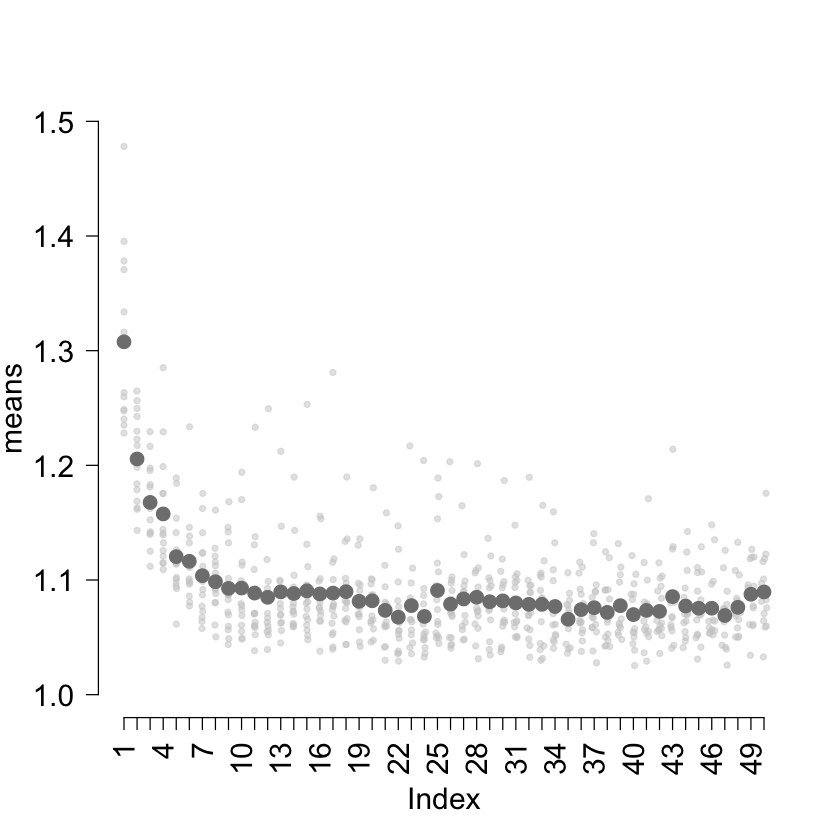

In [27]:
fd = list()
for(i in 1:length(iterative_windows)){
  x = c()
  for(j in 1:length(iterative_windows[[i]])){
    x = c(x, invisible(fractaldim::fd.estimate(iterative_windows[[i]][[j]]$coords)$fd))
  }
  fd[[names(iterative_windows)[i]]] = x
}

d = plot_results(fd, ylim = c(1,1.5))

<font size="3"> Plot the relationship of Hurst exponent and fractal dimension

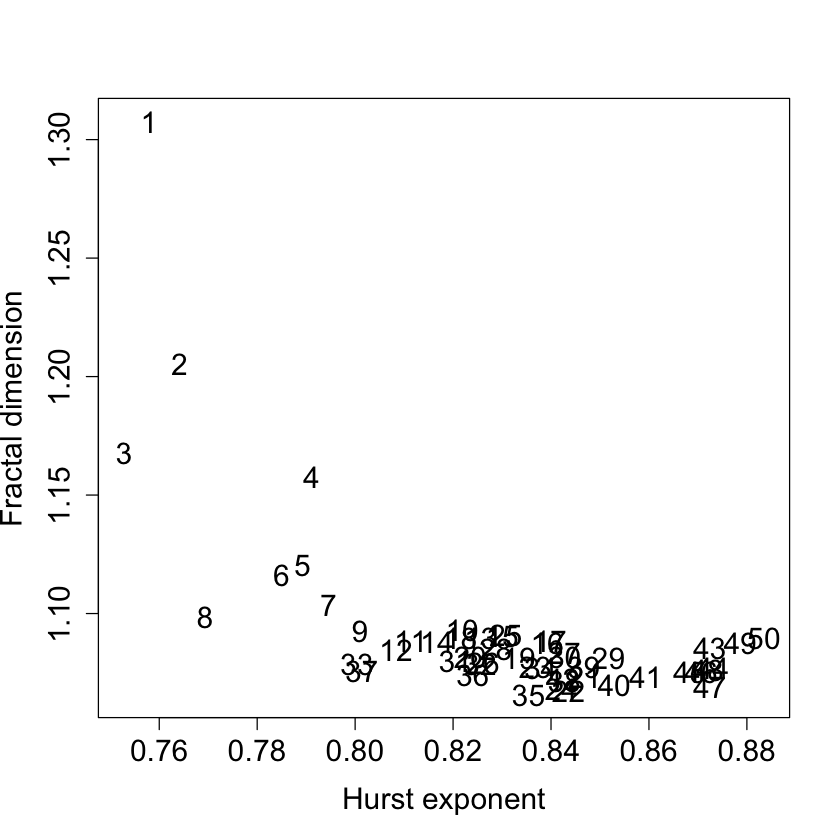

In [28]:
plot(h$means,
     d$means,
     type = 'n',
     ylab = 'Fractal dimension',
     xlab = 'Hurst exponent',
     cex.axis = 1.5,
     cex.lab = 1.5)
text(h$means, d$means,
     lab = names(iterative_windows),
     cex = 1.5)

<font size="3"> Save

In [29]:
saveRDS(recurrence, '02_analysis_files/iterative_windows_recurrence.RDS')

## Calculate feature windows of desired size and run UMAP

<font size="3"> After analyzing the output of the iterative window search, it looks like a window size of 7 frames appears to yield movement spaces that are structurally similar across data replicates (via the analyses of **Procrustes** and **Euclidean** distances) and display desirable temporal qualities (i.e. show little variance in **Recurrence** across replicates).

<font size="3"> In this chunk, we will load in the shape components, extract 7 frame windows for the full dataset, and generate a movement space using the **UMAP** algorithm.

---

<font size="3"> Load PCs

In [30]:
s = readRDS('02_analysis_files/shape_pca_15_pcs.RDS')

<font size="3"> Load data

In [31]:
dat = readRDS('00_data/imoto_et_al_features_all_cells_051822.RDS')

<font size="3"> Get windows of desired size

In [32]:
win = get_windows(s, window_size = 7)

<font size="3"> Run UMAP on windows

In [33]:
u = umap(t(win))

<font size="3"> Extract layout of UMAP

In [34]:
layout = data.frame(x = u$layout[,1],
                    y = u$layout[,2])

<font size="3"> Bin UMAP layout

In [35]:
layout = bin_umap(layout, 
                  n_bins = 64)$layout

<font size="3"> Add metadata to layout

In [36]:
#Unique ID (cell type + trial)
layout$id = rownames(dat)[1:nrow(layout)]

#Cell type
layout$cell = unlist(lapply(strsplit(layout$id, "_"), function(v){v[1]}))

#Trial
layout$trial = paste(unlist(lapply(strsplit(layout$id, "_"), function(v){v[1]})),
                     unlist(lapply(strsplit(layout$id, "_"), function(v){v[2]})),
                     sep = '_')

#Time
layout$time = paste(unlist(lapply(strsplit(layout$id, "_"), function(v){v[3]})))

#PCs
feat = s[1:nrow(layout),]
layout = cbind(feat, layout)

<font size="3"> Louvain cluster (used for some downstream analyses)

In [37]:
#Convert layout into graph
g = graph_from_data_frame(as.data.frame(
  cbind(layout[1:(nrow(layout)-1),]$xy_new,
        layout[2:nrow(layout),]$xy_new)), 
                          directed = FALSE)

#Run louvain clustering
partition = cluster_louvain(g)

#Extract cluster membership
m = partition$membership
names(m) = partition$names

#Add Louvain clusters to layout
layout$louvain_cluster = rep(NA, nrow(layout))
for(i in 1:length(m)){
  layout[layout$xy_new == names(m)[i],]$louvain_cluster = m[i]}

<font size="3"> Save

In [38]:
#saveRDS(u, '02_analysis_files/behavior_space_full_umap_output.RDS')
#saveRDS(layout, '02_analysis_files/behavior_space_layout_annotated.RDS')